# MNIST - Kuskapskontroll 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import cv2
from scipy import ndimage



# Data

In [4]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

np.random.seed(42)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

# EDA

Dataset shape: (70000, 784)
Number of classes: 10


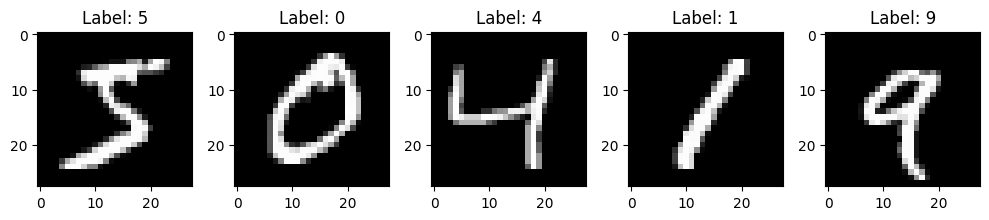

In [3]:
print("Dataset shape:", X.shape)
print("Number of classes:", len(np.unique(y)))

plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i].reshape(28,28), cmap='gray')
    plt.title(f'Label: {y[i]}')
plt.tight_layout()
plt.show()

# Modelling

In [6]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [8]:
random_forest_clf.fit(X_train, y_train)
random_forest_clf.score(X_val, y_val)

0.9692

In [7]:
extra_trees_clf.fit(X_train, y_train)
extra_trees_clf.score(X_val, y_val)

0.9715

In [14]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf)
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)
voting_clf.score(X_val, y_val)

0.9713

In [8]:
best_model = extra_trees_clf
best_model.fit(X_train_val, y_train_val)

ExtraTreesClassifier(random_state=42)

# Evaluation


Test set accuracy of the retrained best model: 0.9682


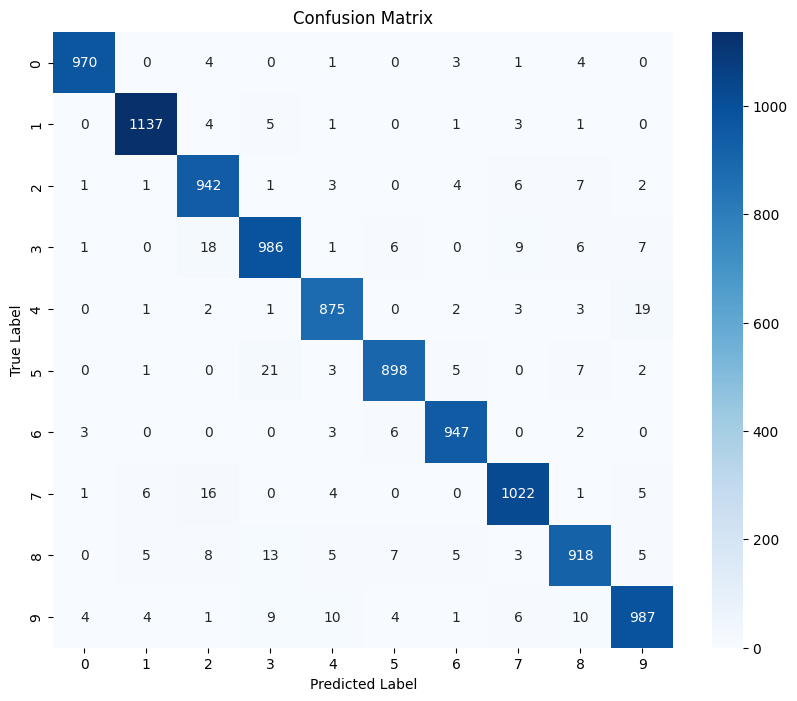

In [17]:
print(f"\nTest set accuracy of the retrained best model: {best_model.score(X_test, y_test)}")
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Examples of wrongly predicted numbers

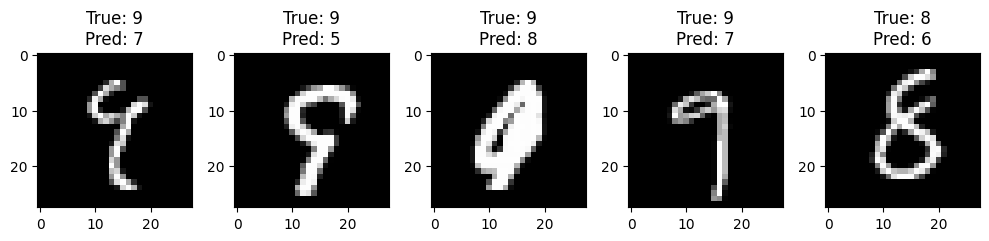

In [21]:
mistakes_idx = y_test != y_pred # creates array of booleans
X_mistakes = X_test[mistakes_idx]
y_true = y_test[mistakes_idx]
y_predicted = y_pred[mistakes_idx]

plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_mistakes[i].reshape(28,28), cmap='gray')
    plt.title(f'True: {y_true[i]}\nPred: {y_predicted[i]}')
plt.tight_layout()
plt.show()

Examples of correct predicted numbers

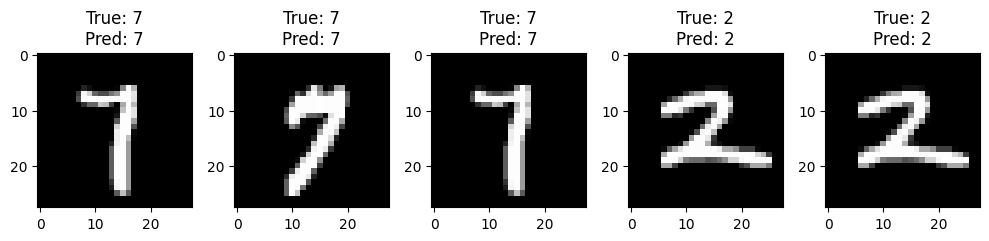

In [22]:
correct_idx = y_test = y_pred # creates array of booleans
X_correct = X_test[correct_idx]
y_true = y_test[correct_idx]
y_predicted = y_pred[correct_idx]

plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_correct[i].reshape(28,28), cmap='gray')
    plt.title(f'True: {y_true[i]}\nPred: {y_predicted[i]}')
plt.tight_layout()
plt.show()

# Summary and analysis

In this experiment, we evaluated three different models on the MNIST dataset: Random Forest, Extra Trees Classifier and a Voting Classifier combining both. The models were trained on 50,000 images, validated on 10,000 images, and finally tested on 10,000 images.

The Extra Trees Classifier emerged as the best performing model, achieving a test accuracy of 96.82%.

The confusion matrix shows that most digits are classified correctly, with some common confusions between visually similar digits (like 5/3, 4/9 and 3/2). The visualization of misclassified examples helps understand where the model struggles, perhaps often with images that even a human would struggle with (specifically examples 1 and 3)

Interestingly, the Voting Classifier, despite combining the predictions of both Random Forest and Extra Trees, did not improve upon the individual performance of the Extra Trees Classifier.

Key findings:
- Extra Trees Classifier performs best with 96.82% test accuracy
- Simple ensemble methods works well for this type of problem
- Adding more complexity through voting did not improve performance

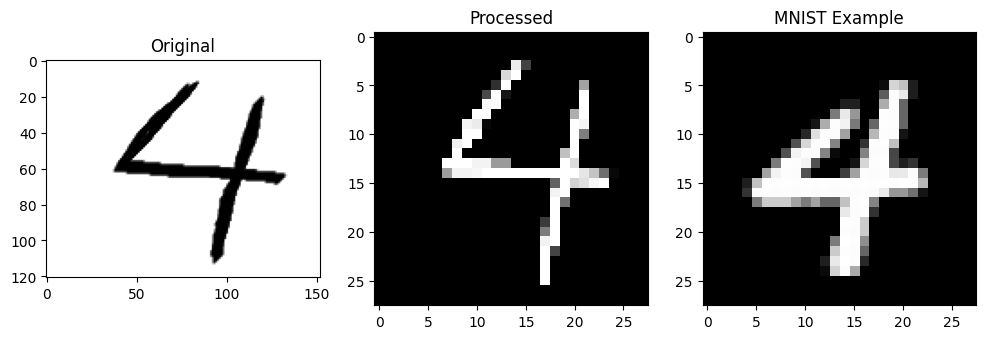

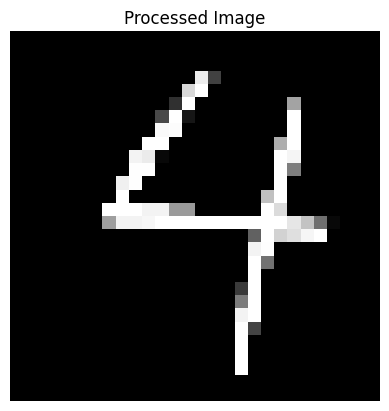

The model predicts this is a: 7

Probabilities for each digit:
Digit 0: 0.0100
Digit 1: 0.2200
Digit 2: 0.0000
Digit 3: 0.0500
Digit 4: 0.0400
Digit 5: 0.1000
Digit 6: 0.0800
Digit 7: 0.4500
Digit 8: 0.0000
Digit 9: 0.0500


In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img.mean() > 127:
        img = 255 - img
    img = cv2.resize(img, (28, 28))
    img = img.astype('float32') / 255.0

    return img

image_path = "handwritten_number.png"

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
processed_img = preprocess_image(image_path)

plt.imshow(processed_img, cmap='gray')
plt.title('Processed Image')
plt.axis('off')
plt.show()

img_for_prediction = processed_img.reshape(1, -1)
prediction = best_model.predict([processed_img.ravel()])[0]
prediction_proba = best_model.predict_proba(img_for_prediction)

print(f"Prediction: {prediction}")
for digit, prob in enumerate(prediction_proba[0]):
    print(f"Digit {digit}: {prob:.4f}")